# Introduction to Data Science
## Project - Phase 2
## Dr. Bahrak & Dr. Yaghoobzadeh
### Kasra Ghorbani // 810101489
### Mohammad Samadi // 810101465

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC



### Load Preprocessed Dataset
In the previous phase of the project, We preprocessed the dataset and applied feature engineering techniques on it.

In [84]:
df = pd.read_csv("./preprocessed_data.csv")
df.drop("Unnamed: 0", axis=1, inplace=True)

In [4]:
for col in ["Is_top_prev_club", "under 30", "is long-term contract"]:
        df[col] = df[col].apply(lambda x: 1 if x == True else 0)

separating only contracts signed in clubs of top 5 european leagues.

In [5]:
df = df[df["Is_top_5_League"] == True]

### Feature Engineering and Feature Selection
These are all the available features.

In [85]:
df.columns

Index(['Division', 'Based', 'Nat', 'Last Club', 'Last Trans. Fee',
       'Is_top_5_League', 'Based_rich_nation', 'Is_top_ranked_nation',
       'EU_National', 'Caps', 'Apps', 'Age', 'Reputation', 'Is_top_prev_club',
       'Salary', 'Begins Year', 'Expires Year', 'Begins Month',
       'Expires Month', 'under 30', 'Age Signing Contract',
       'Contract Duration', 'is long-term contract', 'Games Played'],
      dtype='object')

### Remove less-important features
These are all the available features for use in models. After analyzing them, we can conclude:
- *Based* is the same as *Division*, making it redundant
- *Nat* isn't useful.
- *Last Club* has 781 unique values and is not a good feature for our classification problem.
- *Is Top 5 League*, *Based Rich Nation* are constant (True) across all samples, providing no variation.
- *Begins Month* and *Expires Month* are weakly correlated with the target. Before dropping them, we'll extract a new feature representing whether the contract was signed in the summer window (0), winter wondow (1), or neither (2).
- *Begins Year*, *Expires Year*, and *Contract Duration* contributed to the derived *Is Long-Term* feature. Keeping them might lead to overfitting or inflated evaluation metrics.
- *Age Signing Contract* is more relavent to the target than *Age*, so we can drop *Age*.

Extract a new feature from month of the date each contract was signed.

In [6]:
summer_transfer_window_months = [5, 6, 7, 8, 9, 10]
winter_transfer_window_months = [12, 1, 2]
df["Transfer Window"] = df["Begins Month"].apply(lambda x: 0 if x in summer_transfer_window_months else 1 if x in winter_transfer_window_months else 2)

Encode *Division* to numbers.

In [7]:
league_to_int = {'Ligue 1 Uber Eats': 1,
                 'LALIGA EA SPORTS': 4,
                 'Premier League': 5,
                 'Bundesliga': 2,
                 'Serie A TIM': 3}
df["Division"] = df["Division"].apply(lambda x: league_to_int[x])

And finally these are the selected features.

In [8]:
selected_columns = ['Division', 'Last Trans. Fee', 'Is_top_ranked_nation', 'EU_National',
       'Caps', 'Apps', 'Reputation', 'Is_top_prev_club', 'Salary',
       'Transfer Window', 'under 30', 'Age Signing Contract',  'is long-term contract']

less correlated and relavent columns to the target are droped.

In [9]:
TARGET = 'is long-term contract'
df = df[selected_columns]

Split data into train and validation parts.

In [40]:
X_train, X_test, y_train, y_test = train_test_split(df.drop([TARGET], axis=1), df[TARGET], train_size=0.8, random_state=17)

### Choosing an Evaluation Metric for Binary Classification

Before start building models, we need to choose an classification metric to evaluate the models.

First let's see what is a Confusion Matrix. It has four values:
- True Positive (TP): The number of correct positive predictions.
- True Negative (TN): The number of correct negative predictions.
- False Positive (FP): The number of incorrect positive predictions.
- False Negative (FN): The number of incorrect negative predictions.

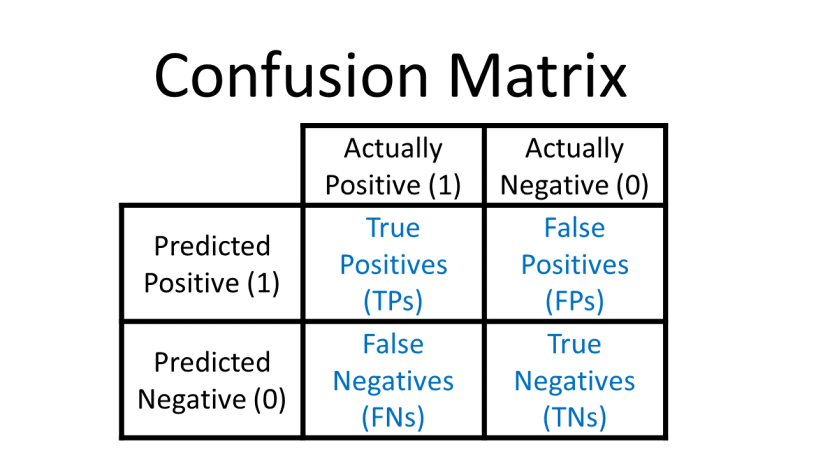

The following metrics can be calculated from the four values of confusion matrix:
- *Accuracy:* the proportion of correct predictions made by the model out of all the predictions made by it. It is How often the model makes correct predictions. It's high even if the model is very cautious
$$ \frac {TP + TN} {TP + TN + FP + FN} = \frac {T} {T + F} $$
- *Precision:* the proportion of correct predictions made by the model out of all the predictions to the value. It shows us how precise the model is when predicting the positive class. It is the ratio of correctly predicted positives to the total predicted positives.
$$ \frac {TP} {TP + FP} = \frac {TP} {P} $$
- *Recall:* the proportion of correct predictions made by the model out of all the observations on that model. It tells us how good the model is at finding all positive instances.
$$ \frac {TP} {TP + FN} $$
- *F1 Score:* mean of $\frac{1}{Precision}$ and $\frac{1}{Recall}$ Also knows as harmonic mean. providing a single metric that balances the effects of both.
$$ \frac{1}{F1} = \frac{1}{2} (\frac{1}{Recall} + \frac{1}{Precision}) \quad \to \quad F1 = 2 \times \frac{Precision \times Recall} {Precision + Recall} $$

The dataset requires binary classification, where label 1 represents a long-term contract and label 0 represents a short-term contract. Considering that it is more important not to mislabel 0 (short-term) as 1 (long-term), an appropriate evaluation metric for this dataset would be the Precision, which measures the proportion of correctly predicted 1's among all predicted 1's, could also be suitable for this task. In conclusion we want a model with less FP as possible.

These two functions are for evaluating models at each step. First one returns four known classification metrics and the second one plots the confusion matrix.

In [57]:
def evaluate_model_on_test(y_test, y_pred):
    return {
            "accuracy":   accuracy_score(y_true=y_test, y_pred=y_pred),
            "precision":  precision_score(y_true=y_test, y_pred=y_pred).round(2),
            "recall":     recall_score(y_true=y_test, y_pred=y_pred).round(2),
            "f1":         f1_score(y_true=y_test, y_pred=y_pred).round(2)
           }

import seaborn as sns
import matplotlib.pyplot as plt

def visualize_confusion_matrix(y_true, y_pred):
    mat = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(mat, cmap='coolwarm', annot=True, linewidths=0.5)
    plt.title('Confusion Matrix')
    plt.show()

First we'll start with a simple Decision Tree model wituout hyparameter tuning.

In [47]:
DT_model = DecisionTreeClassifier(random_state=17, criterion="log_loss")
DT_model.fit(X_train, y_train)
DT_pred = DT_model.predict(X_test)

82% accuracy is not bad. As we can see there are about 170 mislabeled data. In further steps we'll try to improve it

{'accuracy': 0.8274428274428275, 'precision': 0.89, 'recall': 0.87, 'f1': 0.88}


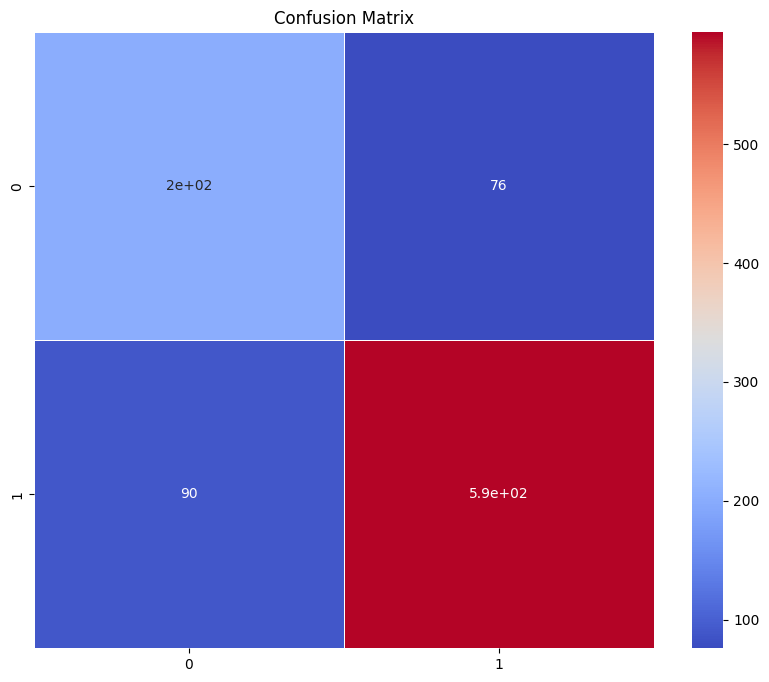

In [48]:
print(evaluate_model_on_test(y_test=y_test, y_pred=DT_pred))
visualize_confusion_matrix(y_true=y_test, y_pred=DT_pred)

Visualizing the tree may reveal potential issues. As shown below, the tree appears to be overfitted. To address this issue, in the next version of the tree, we'll use pruning techniques and employ early stopping to prevent overfitting and improve generalization.

In [67]:
def visualize_decision_tree(model):
    plot_tree(decision_tree=model, feature_names=model.feature_names_in_,
          label="root", filled=True, impurity=True, node_ids=False,
          proportion=True, rounded=True, precision=2)

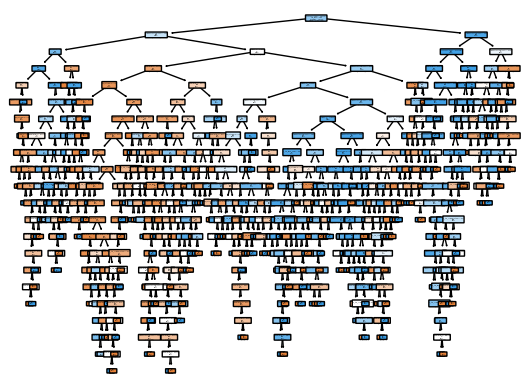

In [49]:
visualize_decision_tree(model=DT_model)

First let's use Grid Search CV method to tune the hyperparameters of the Tree.

In [94]:
def find_best_params(model, param_grid, k):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=k, verbose=1, return_train_score=True)
    grid_search.fit(X=X_train, y=y_train)
    print("Top Accuracy:", grid_search.best_score_)
    print("Best parameters:", grid_search.best_params_)
    # grid_search.cv_results_

In [54]:
DT_params = {
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random']
}

# find_best_params(DecisionTreeClassifier(), DT_params)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Top Accuracy: 0.8553966189856956
Best parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'splitter': 'best'}


In [59]:
DT_model = DecisionTreeClassifier(random_state=17, criterion="gini", max_depth=5, min_samples_leaf=4, max_leaf_nodes=10, min_samples_split=2, splitter='best')
DT_model.fit(X_train, y_train)
DT_pred = DT_model.predict(X_test)

3% of accuracy growth is good but is not enough. This tree mislabeled 150 data (20 less than the init tree).

{'accuracy': 0.8482328482328483, 'precision': 0.88, 'recall': 0.91, 'f1': 0.9}


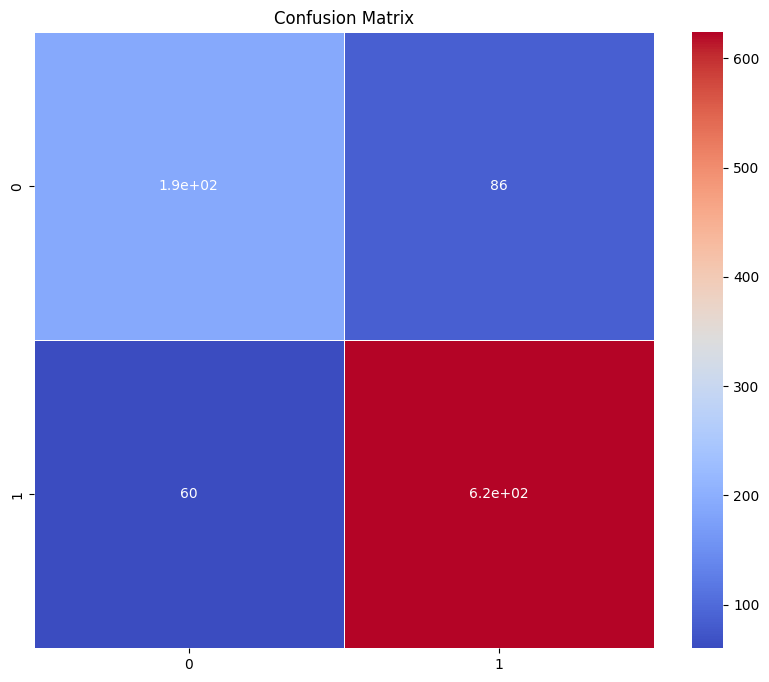

In [60]:
print(evaluate_model_on_test(y_test=y_test, y_pred=DT_pred))
visualize_confusion_matrix(y_true=y_test, y_pred=DT_pred)

As we can see the tree is well pruned.

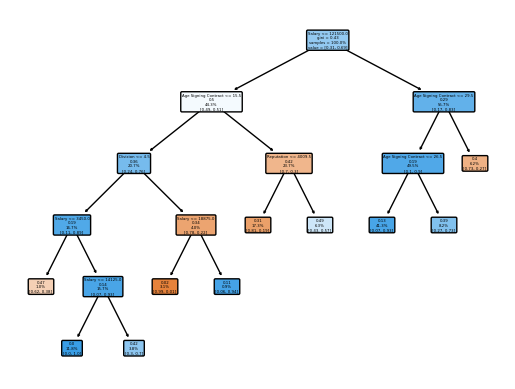

In [61]:
visualize_decision_tree(DT_model)

Now let's use a more powerful ML algorithm. Random Forest consists of *n_estimators* Decision Trees and assigns the label of each data point to the majority class predicted by all trees. We also used GSCV here to find a good set of parameters.

In [62]:
RF_params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [5, None],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_features': ["sqrt", "log2"],
    'bootstrap': [True, False]
}

# find_best_params(RandomForestClassifier(random_state=17), RF_params)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Top Accuracy: 0.8801040312093628
Best parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200}


In [63]:
RF_model = RandomForestClassifier(random_state=17, bootstrap=True, criterion="entropy", max_features="sqrt", n_estimators=200)
RF_model.fit(X_train, y_train)
RF_pred = RF_model.predict(X_test)

3% more accuracy than the best Decision Tree we built and 6% more than the initial tree. It mislabeled about 120 data points.

{'accuracy': 0.8711018711018711, 'precision': 0.9, 'recall': 0.92, 'f1': 0.91}


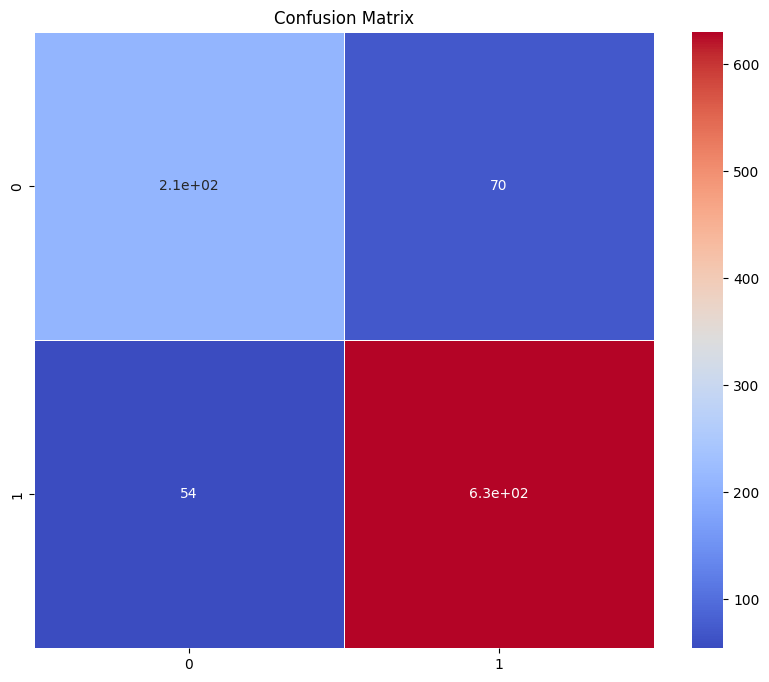

In [64]:
print(evaluate_model_on_test(y_test=y_test, y_pred=RF_pred))
visualize_confusion_matrix(y_true=y_test, y_pred=RF_pred)

Another powerful model is XGboost (short for Extreme Gradient Boosting). Like Random Forest algorithm it uses several Decision Tress too. But XGBoost uses a boosting approach, whereas Random Forest uses the bagging method. It often provides better performance and computational efficiency than Random Forest. 

In [32]:
import xgboost as xgb
params = {
    'max_depth': 5,
    'n_estimators': 100,
    'objective': 'binary:logistic'
}

model = xgb.XGBClassifier()

model.fit(X_train, y_train)

XG_pred = model.predict(X_test)

We'll use Grid Search Cross Validation algorithm to tune the parameters.

In [101]:
XG_params = {
    'n_estimators': [400],
    'max_depth': [5, 7, None],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.5, 0.8, 1],
    'min_child_weight': [1, 5, 10],
    'gamma': [1, 3, 5]
}

xgb.XGBClassifier()
model = xgb.XGBClassifier(learning_rate=0.1, n_estimators=200)

find_best_params(model, XG_params, k=3)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Top Accuracy: 0.876722594274575
Best parameters: {'gamma': 1, 'learning_rate': 0.01, 'max_depth': None, 'n_estimators': 400}


In [140]:
model = xgb.XGBClassifier(objective="binary:logistic", learning_rate=0.10, max_depth=10,
                          n_estimators=300, colsample_bytree=0.6, min_child_weight=1, gamma=0.5)
model.fit(X_train, y_train)
XG_pred = model.predict(X_test)

The current model shows a slight improvement in accuracy when compared to the Random Forest model. Both models show high accuracy, indicating good performance.

{'accuracy': 0.8794178794178794, 'precision': 0.91, 'recall': 0.92, 'f1': 0.92}


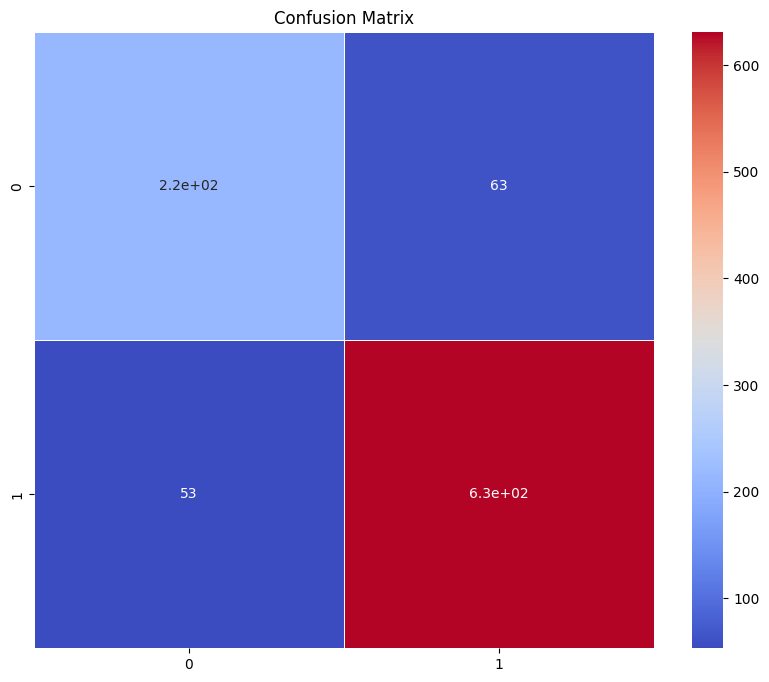

In [141]:
print(evaluate_model_on_test(y_test=y_test, y_pred=XG_pred))
visualize_confusion_matrix(y_true=y_test, y_pred=XG_pred)

### Dimension Reduction
### What is PCA?
Principal Component Analysis is a dimensionality reduction technique. Its primary purpose is to transform high-dimensional data into a lower-dimensional representation while maintaining the most important information. This is particularly useful when dealing with datasets with a large number of features like our raw dataset.

In [72]:
from sklearn.decomposition import PCA

def reduce_dimensions(n, features):
    pca = PCA(n_components=n)
    reduced_features = pca.fit_transform(features)
    return reduced_features

PCA is sensitive to the variances of the features, and if features are on different scales, PCA will give more weight to the features with larger variances (which often correspond to larger scales).

Normalization (or standardization) ensures that each feature contributes equally to the result by giving them all the same scale. This is typically done by subtracting the mean and dividing by the standard deviation for each feature.

In [18]:
from sklearn.preprocessing import StandardScaler
X = df.drop('is long-term contract', axis=1)
scaler = StandardScaler()
X = scaler.fit_transform(X)

#### How to choose the number of components to use in PCA?
A common approach is to choose a threshold for the cumulative explained variance ratio (we used 95% here). We'll calculate this ratio for each principal component and find the smallest number of components that exceed your threshold.

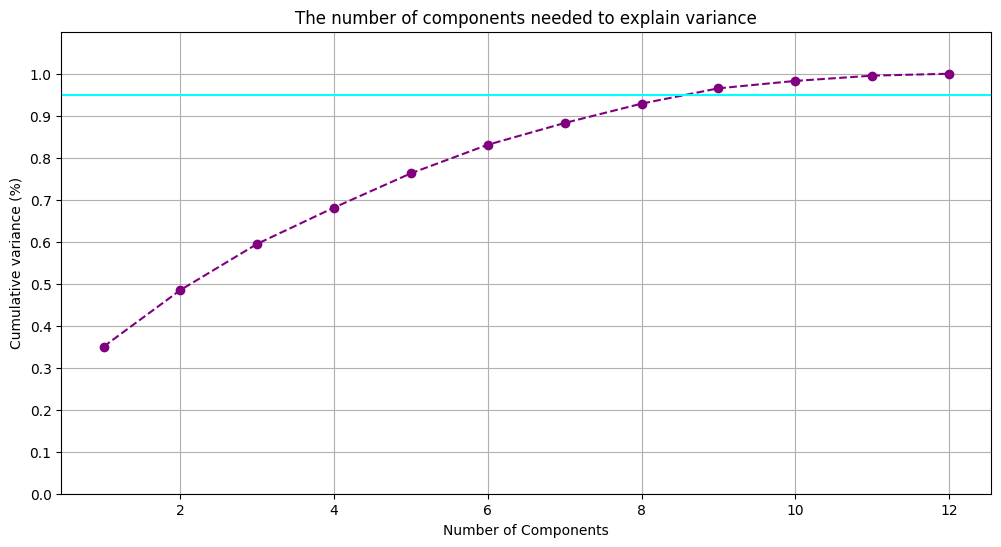

In [24]:
import matplotlib.pyplot as plt

def plot_explained_variances(df):
    pca = PCA().fit(df)
    plt.rcParams["figure.figsize"] = (12,6)
    fig, ax = plt.subplots()
    plt.ylim(0.0,1.1)
    plt.plot([i+1 for i in range(df.shape[1])], np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--', color='purple')
    plt.axhline(y=0.95, color='cyan', linestyle='-')
    plt.xlabel('Number of Components')
    plt.xticks(np.arange(start=2, stop=df.shape[1] + 1, step=2))
    plt.ylabel('Cumulative variance (%)')
    plt.yticks(np.arange(start=0, stop=1.1, step=0.1))
    plt.title('The number of components needed to explain variance')
    plt.grid(True)
    plt.show()
plot_explained_variances(df=X)
num_components = 9 

We'll reduce the number of dimensions twice. first one to 9 (based on explained variance) and the second time to 2 (probably will be used for visualization)

In [46]:
df.reset_index(inplace=True)
X2 = reduce_dimensions(n=2, features=X)
X2 = pd.DataFrame(X2)
X2[TARGET] = df[TARGET]

X9 = reduce_dimensions(n=9, features=X)
X9 = pd.DataFrame(X9)
X9[TARGET] = df[TARGET]

In [51]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2.drop([TARGET], axis=1), X2[TARGET], train_size=0.8, random_state=17)

We'll train the best-performing model (which is XGBoost) on these two feature spaces too.

In [56]:
import xgboost as xgb

model2 = xgb.XGBClassifier(objective="binary:logistic", learning_rate=0.10, max_depth=10,
                          n_estimators=300, colsample_bytree=0.6, min_child_weight=1, gamma=0.5)
model.fit(X_train2, y_train2)
XG_pred2 = model.predict(X_test2)

{'accuracy': 0.7941787941787942, 'precision': 0.84, 'recall': 0.88, 'f1': 0.86}


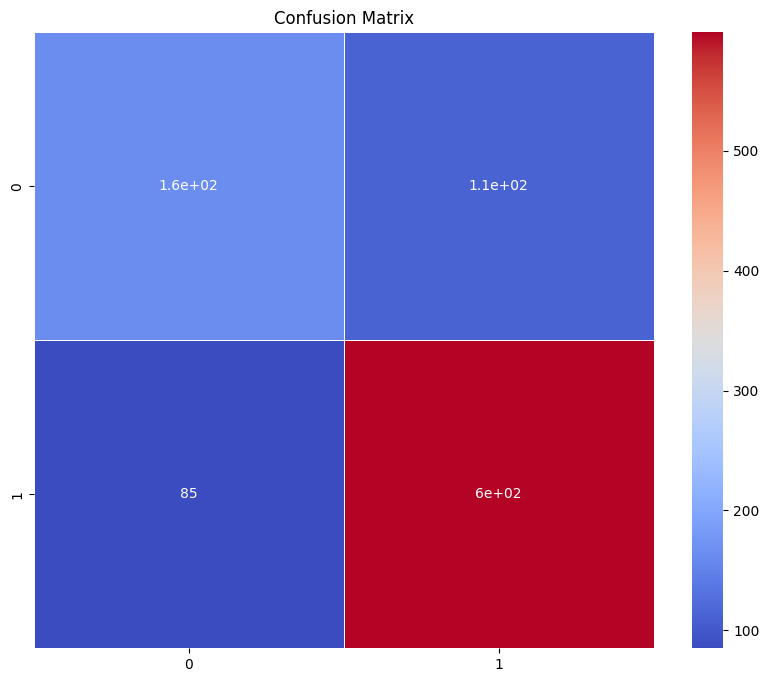

In [58]:
print(evaluate_model_on_test(y_test=y_test2, y_pred=XG_pred2))
visualize_confusion_matrix(y_true=y_test2, y_pred=XG_pred2)

In [83]:
import plotly.express as px
from plotly.subplots import make_subplots
px.scatter(data_frame=X2, x=0, y=1, color="is long-term contract",
           color_discrete_map={0: 'purple', 1: 'cyan'}).show()

In [59]:
X_train9, X_test9, y_train9, y_test9 = train_test_split(X9.drop([TARGET], axis=1), X9[TARGET], train_size=0.8, random_state=17)

In [61]:
model9 = xgb.XGBClassifier(objective="binary:logistic", learning_rate=0.10, max_depth=10,
                          n_estimators=300, colsample_bytree=0.6, min_child_weight=1, gamma=0.5)
model.fit(X_train9, y_train9)
XG_pred9 = model.predict(X_test9)

{'accuracy': 0.8284823284823285, 'precision': 0.87, 'recall': 0.89, 'f1': 0.88}


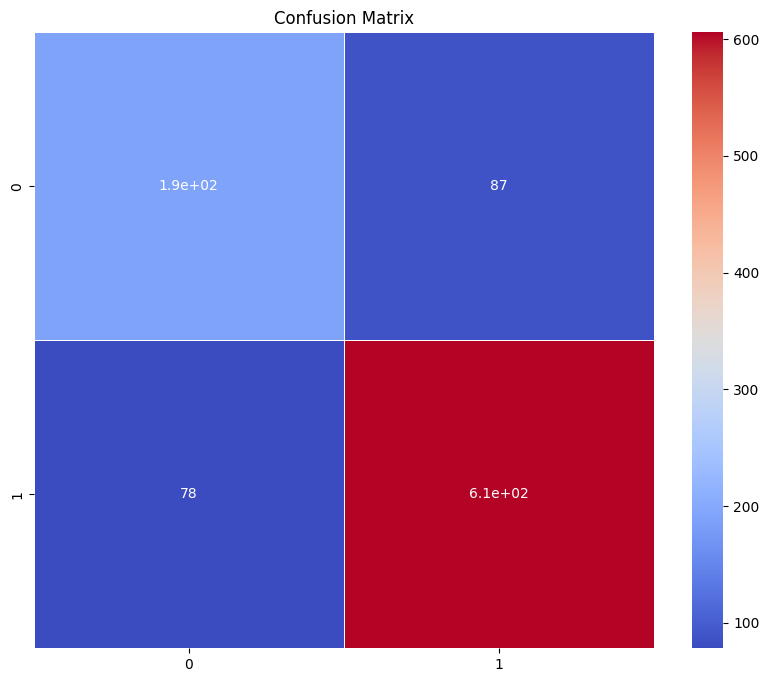

In [62]:
print(evaluate_model_on_test(y_test=y_test9, y_pred=XG_pred9))
visualize_confusion_matrix(y_true=y_test9, y_pred=XG_pred9)

### Model Performance with Reduced Feature Space
The model's performance declined when using a reduced feature space, likely because we initially selected the features carefully. Reducing the feature space may result in the loss of valuable information that could be important for accurate predictions. Applying PCA on the raw dataset and then fitting a model on it would probably help to get a better result than performance of that model on the raw dataset itself.